Here's an extensive summary in markdown format, drawing on the provided sources and our conversation history, with some bolding to highlight key concepts:

**Tool Calling with Chat Models in LangChain**

*   **Purpose**: This guide explains how to use chat models to call tools, which allows the model to generate structured outputs by calling external tools or functions. It's important to note that "tool calling" doesn't mean the model executes the tool itself, but instead generates the arguments required to call a tool. The actual running of the tool is left to the user.
*   **General Technique:** Tool calling is a method for generating structured output from a model, which can also be used even if you do not intend to invoke any tools, for example, extracting information from unstructured text.

**Defining Tool Schemas**
*   **Tool Schemas**: To enable a model to call tools, you need to provide tool schemas that describe what each tool does and the arguments it requires.
*   **`.bind_tools()` Method**: Chat models supporting tool-calling features implement a `.bind_tools()` method for passing tool schemas. These schemas are then passed with the prompt during subsequent model invocations.
*   **Schema Formats**: Tool schemas can be defined in several formats:
    *   **Python Functions**: Using Python functions with type hints and docstrings. The function name, type hints, and docstrings are all part of the tool schema.
        ```python
        def add(a: int, b: int) -> int:
            """Add two integers.
            Args:
                a: First integer
                b: Second integer
            """
            return a + b
        ```
    *   **LangChain Tool Objects**: Using the `@tool` decorator for additional control over the tool schema, such as tool names and argument descriptions.
    *   **Pydantic Models**: Defining schemas using Pydantic classes. Note that all fields are required by default unless a default value is provided.
        ```python
        from pydantic import BaseModel, Field
        class add(BaseModel):
            """Add two integers."""
            a: int = Field(..., description="First integer")
            b: int = Field(..., description="Second integer")
        ```
    *  **TypedDict Classes**: Using TypedDicts and annotations (requires `langchain-core>=0.2.25`). Annotations must have a type, and can optionally include a default value and description.
        ```python
        from typing_extensions import Annotated, TypedDict
        class add(TypedDict):
            """Add two integers."""
            a: Annotated[int, ..., "First integer"]
            b: Annotated[int, ..., "Second integer"]
        ```
*  **Binding Schemas:** The `.bind_tools()` method converts the schemas to the correct format for the model. The tool schema is passed every time the model is invoked.

**Invoking the Model**

*   **Tool Argument Generation**: When the model is invoked, it generates arguments for the specified tools.
*   **`tool_calls` Attribute:** If tool calls are included in an LLM response, they are attached to the corresponding message or message chunk as a list of tool call objects in the `.tool_calls` attribute.  Chat models can call multiple tools at once.
*   **`ToolCall` Structure:** A `ToolCall` is a typed dictionary that includes the tool name, a dictionary of argument values, and an optional identifier. Messages without tool calls have an empty list for this attribute.
*   **Multiple Tool Calls:** The model can generate arguments for multiple tools in a single response.
*  **Malformed Tool Calls:** If the model outputs malformed tool calls (e.g., invalid JSON arguments), these are populated as instances of `InvalidToolCall` in the `.invalid_tool_calls` attribute.  An `InvalidToolCall` includes a name, string arguments, an identifier, and an error message.

**Parsing**

*   **Output Parsers:** Output parsers can further process the output, for example, by converting values from `.tool_calls` to Pydantic objects using the `PydanticToolsParser`.
    ```python
    from langchain_core.output_parsers import PydanticToolsParser
    chain = llm_with_tools | PydanticToolsParser(tools=[add, multiply])
    ```

**Key Takeaways**

*   Tool calling involves providing tool schemas to a model, enabling it to generate structured outputs in the form of arguments for the specified tools.
*   LangChain's `.bind_tools()` method is central for binding tool schemas to a chat model, and supports schemas from Python functions, LangChain Tool objects, Pydantic models, and TypedDict classes.
*   The model's generated tool calls can be found in the `.tool_calls` attribute of the response, and output parsers like `PydanticToolsParser` can be used to process the tool calls and convert them into structured objects.

This summary provides an overview of how to use tool calling with chat models in LangChain, drawing on the information provided in the sources, and our conversation history, covering key concepts, methods, and options for structuring model outputs.

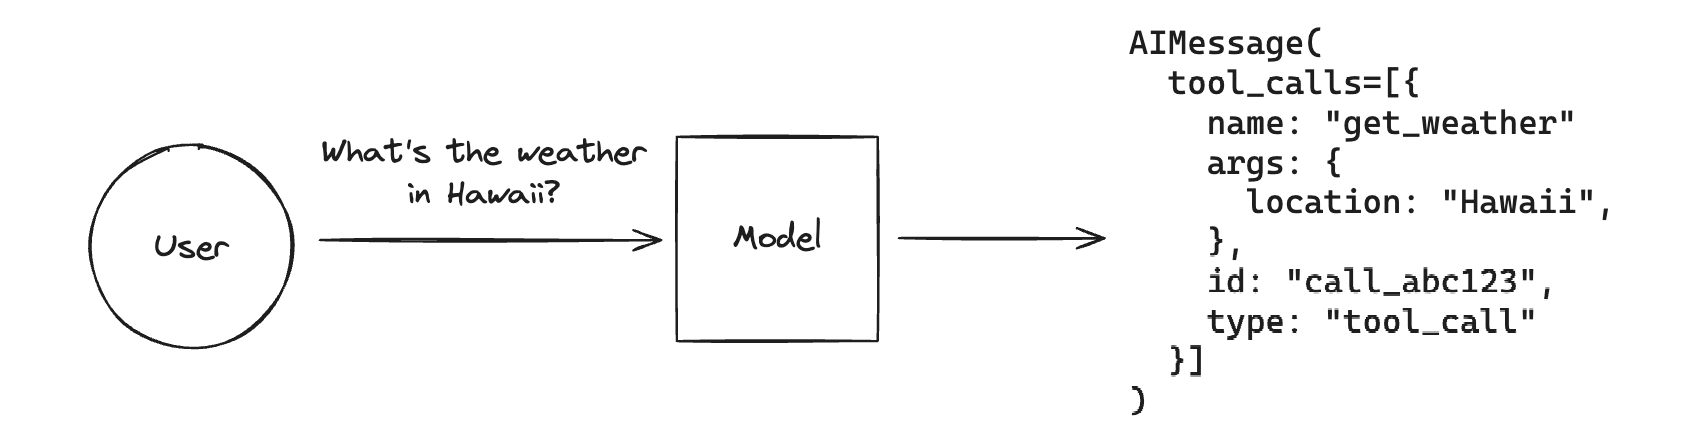

In [1]:
# The function name, type hints, and docstring are all part of the tool
# schema that's passed to the model. Defining good, descriptive schemas
# is an extension of prompt engineering and is an important part of
# getting models to perform well.
def add(a: int, b: int) -> int:
    """Add two integers.

    Args:
        a: First integer
        b: Second integer
    """
    return a + b


def multiply(a: int, b: int) -> int:
    """Multiply two integers.

    Args:
        a: First integer
        b: Second integer
    """
    return a * b

In [2]:
from pydantic import BaseModel, Field


class add(BaseModel):
    """Add two integers."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")


class multiply(BaseModel):
    """Multiply two integers."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")

In [3]:
from typing_extensions import Annotated, TypedDict


class add(TypedDict):
    """Add two integers."""

    # Annotations must have the type and can optionally include a default value and description (in that order).
    a: Annotated[int, ..., "First integer"]
    b: Annotated[int, ..., "Second integer"]


class multiply(TypedDict):
    """Multiply two integers."""

    a: Annotated[int, ..., "First integer"]
    b: Annotated[int, ..., "Second integer"]


tools = [add, multiply]

In [4]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
llm_with_tools = llm.bind_tools(tools)

query = "What is 3 * 12?"

llm_with_tools.invoke(query)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r1XzFwFHDEIrdFCTqmWrNcB1', 'function': {'arguments': '{"a":3,"b":12}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 87, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-43f3037f-7a85-4a01-94f0-24ebdb977eaa-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_r1XzFwFHDEIrdFCTqmWrNcB1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 18, 'total_tokens': 105, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
from langchain_ollama import ChatOllama

ollama = ChatOllama(model='llama3.1')

ollama_with_tools = ollama.bind_tools(tools)

ollama_with_tools.invoke(query)

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-22T18:20:06.17052766Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1551975953, 'load_duration': 1311572872, 'prompt_eval_count': 228, 'prompt_eval_duration': 76000000, 'eval_count': 22, 'eval_duration': 162000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='multiply', arguments={'a': 3, 'b': 12}))])}, id='run-adb81c1a-7a62-475f-bdf4-33cee2faf320-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': '819b188c-e3b6-431e-9dce-581ed1ded333', 'type': 'tool_call'}], usage_metadata={'input_tokens': 228, 'output_tokens': 22, 'total_tokens': 250})

In [7]:
query = "What is 3 * 12? Also, what is 11 + 49?"

llm_with_tools.invoke(query).tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 12},
  'id': 'call_x4VUfbK15TXeuHfTMjhYWa6P',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 11, 'b': 49},
  'id': 'call_LyIMX1b6kHoJe2MLdGZb3YJU',
  'type': 'tool_call'}]

In [8]:
ollama_with_tools.invoke(query).tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 12},
  'id': 'bda002c0-17cb-4709-b8d7-0d3381d45d55',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 11, 'b': 49},
  'id': 'd8b72eef-3fc6-43ae-b39a-e0eea9052a01',
  'type': 'tool_call'}]

In [10]:
from langchain_core.output_parsers import PydanticToolsParser
from pydantic import BaseModel, Field


class add(BaseModel):
    """Add two integers."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")


class multiply(BaseModel):
    """Multiply two integers."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")


chain = llm_with_tools | PydanticToolsParser(tools=[add, multiply])
chain.invoke(query)

[multiply(a=3, b=12), add(a=11, b=49)]